In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    classification_report
)

# 1. Load and Prepare Data
# Load the training dataset from the specified path
try:
    df_train = pd.read_csv("Dataset.csv")
except FileNotFoundError:
    print("Error: Train.csv not found. Please check the file path.")
    exit()

In [5]:
# Minimal preprocessing: Fill missing values with the mean of their respective columns
df_train['V1'].fillna(df_train['V1'].mean())
df_train['V2'].fillna(df_train['V2'].mean())

# Separate the features (X) from the target variable (y)
X = df_train.drop('Target', axis=1)
y = df_train['Target']

# 2. Splitting the Dataset
# Split the data into a training set (80%) and a validation set (20%)
# Using stratify=y ensures that both train and validation sets have a similar proportion of target classes
print("Splitting the dataset into training (80%) and validation (20%) sets...")
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_valid.shape}\n")

# 3. Handle Class Imbalance using Undersampling 
# The notebook showed the data is highly imbalanced. We'll use RandomUnderSampler on the training data.
print("Applying RandomUnderSampler to balance the training data...")
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print(f"Shape of resampled training data: {X_train_resampled.shape}\n")

# 4. Feature Scaling 
# Scale the features to have zero mean and unit variance for better model performance
print("Scaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_valid_scaled = scaler.transform(X_valid) # Use the same scaler fitted on the training data
print("Scaling complete.\n")

Splitting the dataset into training (80%) and validation (20%) sets...
Training set shape: (16000, 40)
Validation set shape: (4000, 40)

Applying RandomUnderSampler to balance the training data...
Shape of resampled training data: (1776, 40)

Scaling features using StandardScaler...
Scaling complete.



Training the XGBClassifier model...


Model training complete.

Model Validation Results on the 20% Hold-Out Set
Accuracy:  0.8285
Recall:    0.9234  <-- Primary metric to maximize
Precision: 0.2346
F1-Score:  0.3741

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      3778
           1       0.23      0.92      0.37       222

    accuracy                           0.83      4000
   macro avg       0.61      0.87      0.64      4000
weighted avg       0.95      0.83      0.87      4000

Confusion Matrix:


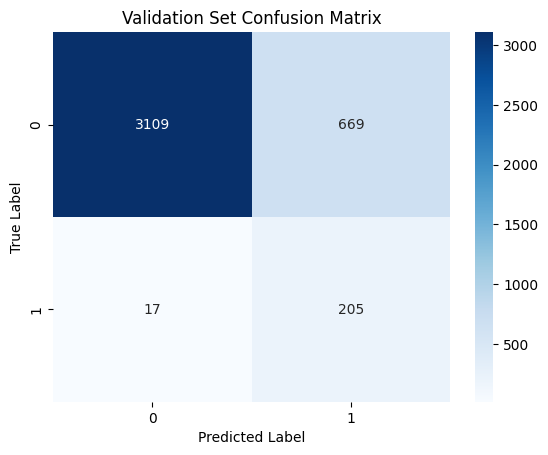

In [ ]:
# 5. Model Training 
# Initialize and train the XGBoost Classifier model
# These parameters are based on the tuned model from the notebook for best recall
print("Training the XGBClassifier model...")
xgb_model = XGBClassifier(
    random_state=1,
    eval_metric='logloss',
    subsample=0.9,
    scale_pos_weight=10,  # Important for imbalanced classes
    n_estimators=200,
    learning_rate=0.2,
    gamma=5 
)

xgb_model.fit(X_train_scaled, y_train_resampled)
print("Model training complete.\n")

#  6. Model Validation 
# Make predictions on the validation set (unseen data)
print("Model Validation Results on the 20% Hold-Out Set")
y_pred_valid = xgb_model.predict(X_valid_scaled)

# Calculate and print performance metrics
accuracy = accuracy_score(y_valid, y_pred_valid)
recall = recall_score(y_valid, y_pred_valid)
precision = precision_score(y_valid, y_pred_valid)
f1 = f1_score(y_valid, y_pred_valid)


print(f"Accuracy:  {accuracy:.4f}")
print(f"Recall:    {recall:.4f}  <-- Primary metric to maximize")
print(f"Precision: {precision:.4f}")
print(f"F1-Score:  {f1:.4f}\n")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_valid, y_pred_valid))

# Display the confusion matrix to visualize performance
print("Confusion Matrix:")
cm = confusion_matrix(y_valid, y_pred_valid)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Validation Set Confusion Matrix')
plt.show()